In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer

import os
os.environ["KERAS_BACKEND"] = "torch"

from keras_core.models import Sequential
from keras_core.layers import Dense, Input
from keras_core.regularizers import l2
from keras_core.layers import Dropout
from keras_core.callbacks import EarlyStopping

Using PyTorch backend.


In [2]:
train = pd.read_csv('../train_complete.csv')
train.dropna(thresh = train.shape[0]*0.8, axis = 1, inplace = True)

In [3]:
column_keep = train.drop(columns='Incidence').columns

In [4]:
train_dummy = pd.get_dummies(train, columns=['Age'], drop_first=True)

In [5]:
test = pd.read_csv('../test_complete.csv')

In [6]:
test = test[column_keep]

In [7]:
test_dummy = pd.get_dummies(test, columns=['Age'], drop_first=True)

In [8]:
test_numeric = test_dummy.drop(columns=['ID','State_Name'])

In [9]:
X = train_dummy.drop(columns=['Incidence','ID','State_Name'])
y = train_dummy['Incidence']

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42)

In [11]:
it_imp = IterativeImputer(max_iter=100)
X_train = it_imp.fit_transform(X_train)
X_test = it_imp.transform(X_test)
test_numeric = it_imp.transform(test_numeric)

In [12]:
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

In [13]:
# Model
model = Sequential()
model.add(Input((X.shape[1],)))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1))

# Compile it
model.compile(loss='mse', optimizer='adam', metrics=['mae'])

# Fit it
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=256
)

Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 24390752.0000 - mae: 4696.4219 - val_loss: 24823116.0000 - val_mae: 4760.5767
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 24109316.0000 - mae: 4671.6514 - val_loss: 24783508.0000 - val_mae: 4756.5425
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 24242750.0000 - mae: 4687.9443 - val_loss: 24679616.0000 - val_mae: 4746.1611
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 23762998.0000 - mae: 4631.3511 - val_loss: 24409910.0000 - val_mae: 4719.3994
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 23458480.0000 - mae: 4603.9463 - val_loss: 23757474.0000 - val_mae: 4654.1641
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 22770508.0000 - mae: 4535.5337 - val_loss: 22336982.0000 - val_mae: 4507.5039
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 21181530.0000 - mae: 4372.2280 - val_loss: 19642650.0000 - val_mae: 4207.2749
Epoch 8/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s

### Predict test data

In [14]:
nn_preds = model.predict(test_numeric)

147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 390us/step    


In [15]:
nn_preds

array([[5345047. ],
       [5345272.5],
       [5345488. ],
       ...,
       [5448482. ],
       [5448173. ],
       [5447668. ]], dtype=float32)

In [16]:
test_preds_nn = pd.DataFrame({
    'ID': test['ID'],
    'Incidence': nn_preds.flatten()
})

test_preds_nn.head()

,ID,Incidence
0,6c06615,5345047.0
1,e0cf76e,5345272.5
2,e9f95f0,5345488.0
3,5dffe44,5345157.0
4,9f9ea9b,5345255.0


In [17]:
#test_preds_nn.to_csv('../nn_model.csv', index=False)

In [18]:
# Apply L2 to the model

In [19]:
# Model
model_l2 = Sequential()
model_l2.add(Input((X.shape[1],)))
model_l2.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
model_l2.add(Dense(32, activation='relu', kernel_regularizer=l2(0.01)))
model_l2.add(Dense(32, activation='relu', kernel_regularizer=l2(0.01)))
model_l2.add(Dense(1))
# Compile it
model_l2.compile(loss='mse', optimizer='adam', metrics=['mae'])

# Fit it
history_l2 = model_l2.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=256
)

Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 24162448.0000 - mae: 4674.6660 - val_loss: 24833276.0000 - val_mae: 4761.5991
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 24026136.0000 - mae: 4666.0039 - val_loss: 24815402.0000 - val_mae: 4759.7251
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 24088410.0000 - mae: 4666.4897 - val_loss: 24777522.0000 - val_mae: 4755.8276
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 24139044.0000 - mae: 4669.5684 - val_loss: 24696632.0000 - val_mae: 4747.6421
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step - loss: 23625760.0000 - mae: 4620.8359 - val_loss: 24528086.0000 - val_mae: 4730.6953
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 23506390.0000 - mae: 4611.1279 - val_loss: 24192666.0000 - val_mae: 4697.0005
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step - loss: 23008570.0000 - mae: 4560.5029 - val_loss: 23579716.0000 - val_mae: 4634.9507
Epoch 8/100
14/14 ━━━━━━━━━━━━━━━━━━━

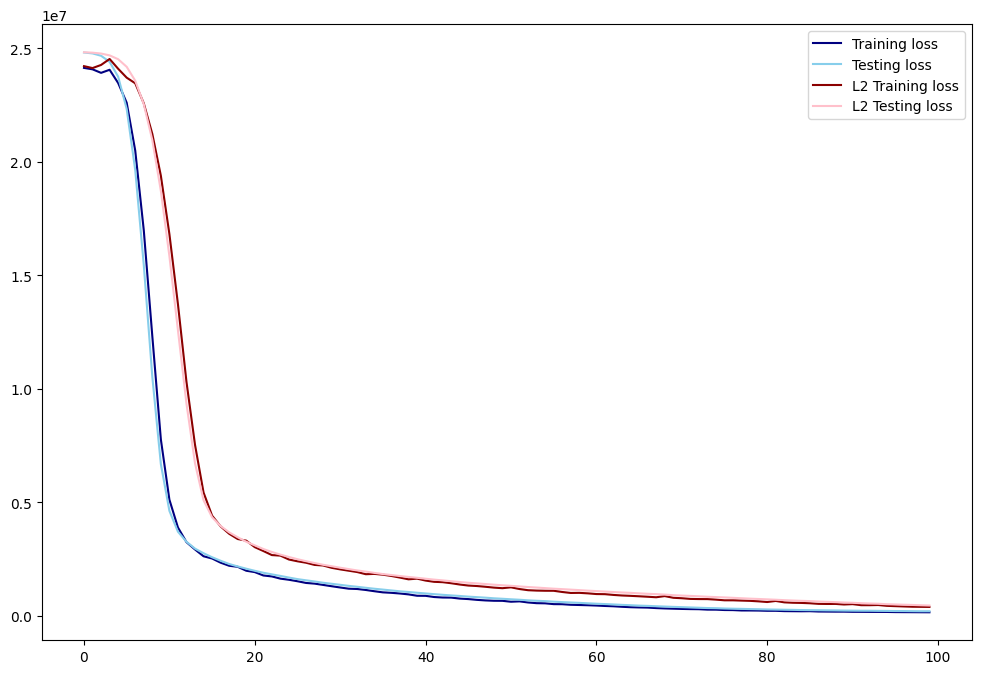

In [20]:
# Visualize loss
train_loss = history.history['loss']
test_loss = history.history['val_loss']
train_loss_l2 = history_l2.history['loss']
test_loss_l2 = history_l2.history['val_loss']

plt.figure(figsize=(12, 8))
plt.plot(train_loss, label='Training loss', color='navy')
plt.plot(test_loss, label='Testing loss', color='skyblue')
plt.plot(train_loss_l2, label='L2 Training loss', color='darkred')
plt.plot(test_loss_l2, label='L2 Testing loss', color='pink')
plt.legend();

In [21]:
# Build a model using Dropout
# Model
model_dropout = Sequential()
model_dropout.add(Input((X.shape[1],)))
model_dropout.add(Dense(64, activation='relu'))
model_dropout.add(Dropout(0.2)) 
model_dropout.add(Dense(32, activation='relu'))
model_dropout.add(Dropout(0.2))
model_dropout.add(Dense(1))
# Compile it
model_dropout.compile(loss='mse', optimizer='adam', metrics=['mae'])

# Fit it
history_dropout = model_dropout.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=128
)

Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 24132330.0000 - mae: 4674.6509 - val_loss: 24982290.0000 - val_mae: 4760.1597
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step - loss: 24374320.0000 - mae: 4697.7661 - val_loss: 24935432.0000 - val_mae: 4755.3389
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 878us/step - loss: 24653830.0000 - mae: 4720.2363 - val_loss: 24820934.0000 - val_mae: 4743.7422
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 861us/step - loss: 24157728.0000 - mae: 4674.8491 - val_loss: 24564962.0000 - val_mae: 4718.0010
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step - loss: 23866246.0000 - mae: 4641.6885 - val_loss: 24089740.0000 - val_mae: 4670.1265
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 861us/step - loss: 22968792.0000 - mae: 4549.0884 - val_loss: 23329770.0000 - val_mae: 4592.4248
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 861us/step - loss: 22558854.0000 - mae: 4502.4072 - val_loss: 22226202.0000 - val_mae: 4477.3110
Epoch 8/100
27/27 ━━━━━━━━━━━

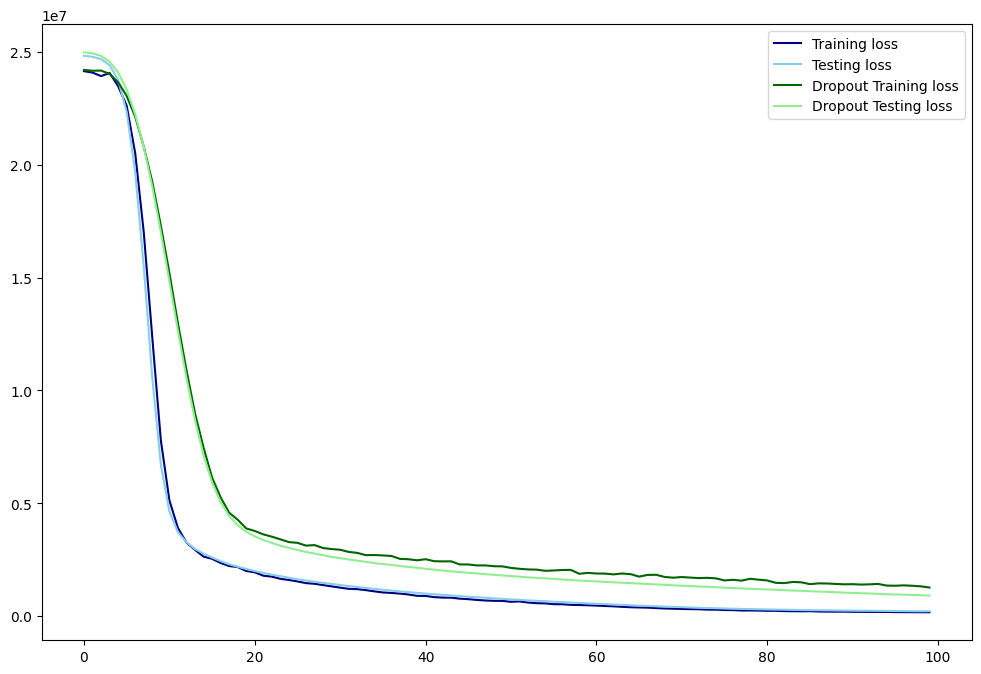

In [22]:
# Visualize loss
train_loss_dropout = history_dropout.history['loss']
test_loss_dropout = history_dropout.history['val_loss']

plt.figure(figsize=(12, 8))
plt.plot(train_loss, label='Training loss', color='navy')
plt.plot(test_loss, label='Testing loss', color='skyblue')
plt.plot(train_loss_dropout, label='Dropout Training loss', color='darkgreen')
plt.plot(test_loss_dropout, label='Dropout Testing loss', color='lightgreen')
plt.legend();

In [23]:
# Build model using early stopping
model_es = Sequential()
model_es.add(Input((X.shape[1],)))
model_es.add(Dense(64, activation='relu'))
model_es.add(Dense(32, activation='relu'))
model_es.add(Dense(1))

# Compile it
model_es.compile(loss='mse', optimizer='adam', metrics=['mae'])

early_stop = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=5,
    verbose=1,
    restore_best_weights=True
)

# Fit it
history_es = model_es.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=128,
    callbacks=[early_stop]
)

Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 24313016.0000 - mae: 4684.1426 - val_loss: 24978584.0000 - val_mae: 4760.0186
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step - loss: 24296594.0000 - mae: 4684.7759 - val_loss: 24922918.0000 - val_mae: 4754.7939
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step - loss: 23973302.0000 - mae: 4659.2612 - val_loss: 24792880.0000 - val_mae: 4742.6162
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step - loss: 23919972.0000 - mae: 4655.1899 - val_loss: 24529380.0000 - val_mae: 4717.7354
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step - loss: 23804460.0000 - mae: 4639.1309 - val_loss: 24070140.0000 - val_mae: 4673.7847
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 695us/step - loss: 23293168.0000 - mae: 4595.2124 - val_loss: 23352594.0000 - val_mae: 4603.6558
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step - loss: 22398338.0000 - mae: 4507.4785 - val_loss: 22328014.0000 - val_mae: 4500.7505
Epoch 8/100
27/27 ━━━━━━━━━━━

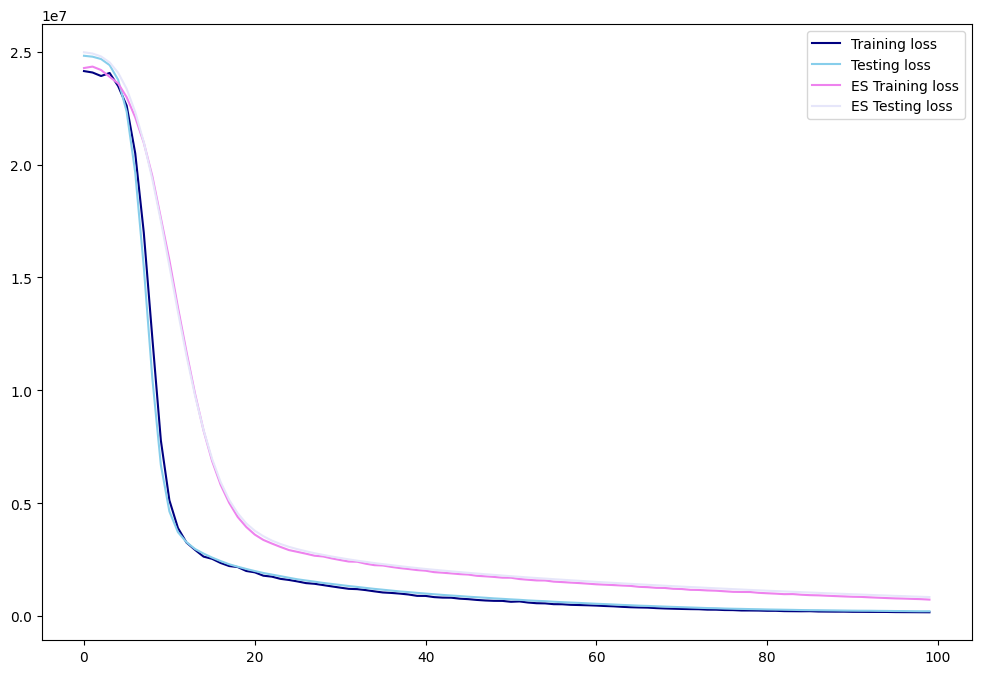

In [24]:
# Visualize loss
train_loss_es = history_es.history['loss']
test_loss_es = history_es.history['val_loss']

plt.figure(figsize=(12, 8))
plt.plot(train_loss, label='Training loss', color='navy')
plt.plot(test_loss, label='Testing loss', color='skyblue')
plt.plot(train_loss_es, label='ES Training loss', color='violet')
plt.plot(test_loss_es, label='ES Testing loss', color='lavender')
plt.legend();

### Result

* Neural Network did not perform better than the other model in 02a notebook.
* In the future, use Kerasregressor to find diffferent better parameter.
* Apply different imputer.
* Separate the imputer step and modeling step into two different notebook